In [15]:
import CentralStreamingModel.biskewt.skewt as st
import matplotlib.pyplot as plt
import numpy as np
import importlib
import seaborn as sns
from CentralStreamingModel.projection.wrap_projection import skewt_los_pdf
from scipy.integrate import simps
from scipy.stats import t, norm
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from scipy.special import gamma


In [16]:
v_los = np.linspace(-30., 30., 100)
r = np.linspace(0.,100.,100)

vr_c = 2.
#vr_c= 1.
kappa = 40
skewness = -0.6
#skewness = -3.

In [17]:
def w(r):
    return 0.1*r + 1.

def norm_pdf(v, loc, scale):
    return norm.pdf(v, loc = loc, scale = scale)  

In [18]:
def oned_skewt(v, v_c, w, alpha, nu):
    
    arg = alpha/w * (v - v_c) * ((nu + 1)/(((v - v_c)/w)**2 + nu))**0.5
    
    return 2/w * t.pdf((v-v_c)/w, scale = 1, df = nu) * t.cdf(arg, df = nu+1, scale = 1)

def truncated_skewt(v, v_c, w, alpha, nu):
    
    pdf = oned_skewt(v, v_c, w, alpha, nu)
    if hasattr(w, "__len__"):
        norm = []
        for w_value in w:
            norm.append(simps(oned_skewt(v_los, v_c,w_value, alpha, nu), v_los))    
    else:
        norm = simps(oned_skewt(v_los, v_c,w, alpha, nu), v_los)
    return pdf/norm

In [19]:
def find_gaussian_parameters(r, v_los):
    st_pdf = np.zeros((len(r), len(v_los)))
    gauss_pdf = np.zeros((len(r), len(v_los)))

    mean = np.zeros((len(r)))
    std = np.zeros_like(mean)

    for i, r_value in enumerate(r):

        st_pdf[i] =  truncated_skewt(v_los, vr_c, w(r_value), skewness, kappa)
        mean[i] = simps(st_pdf[i] * v_los, v_los)
        std[i] = np.sqrt(simps(st_pdf[i] * (v_los - mean[i])**2, v_los))
        
        gauss_pdf[i] = norm.pdf(v_los, loc = mean[i], scale = std[i])  
        
    return mean, std, st_pdf, gauss_pdf

def find_best_fit_gaussian(r, v_los):
    st_pdf = np.zeros((len(r), len(v_los)))
    gauss_pdf = np.zeros((len(r), len(v_los)))

    mean = np.zeros((len(r)))
    std = np.zeros_like(mean)


    for i, r_value in enumerate(r):

        st_pdf[i] =  truncated_skewt(v_los, vr_c, w(r_value), skewness, kappa)
        popt, pcov = curve_fit(norm_pdf, v_los, st_pdf[i])
        mean[i], std[i] = popt

        gauss_pdf[i] = norm.pdf(v_los, loc = mean[i], scale = std[i])  
    return mean, std, st_pdf, gauss_pdf

In [20]:
mean, std, st_pdf, gauss_pdf = find_gaussian_parameters(r, v_los)
mean_bf, std_bf, st_pdf_bf, gauss_pdf_bf = find_best_fit_gaussian(r, v_los)

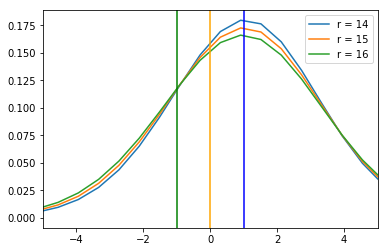

In [21]:
r_plots = [14,15,16]
for r_plot in r_plots:
    plt.plot(v_los, st_pdf[r_plot], label = f'r = {r_plot}')
    
plt.axvline(x = 0, color = 'orange')
plt.axvline(x = 1, color='blue')
plt.axvline(x = -1, color='green')
plt.xlim(-5,5)
plt.legend()

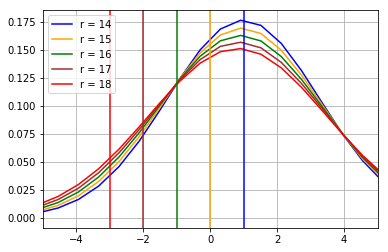

In [22]:
r_plots = [14,15,16,17,18]
colors = ['blue', 'orange', 'green', 'brown','red']
for i, r_plot in enumerate(r_plots):
    plt.plot(v_los, gauss_pdf[r_plot], label = f'r = {r_plot}', color = colors[i])
    
plt.axvline(x = 0, color = 'orange')
plt.axvline(x = 1, color='blue')
plt.axvline(x = -1, color='green')
plt.axvline(x = -2, color='brown')
plt.axvline(x = -3, color='red')

plt.grid()
plt.xlim(-5,5)
plt.legend()

In [23]:
mean_interp = interp1d(r, mean)
std_interp = interp1d(r, std)

In [24]:
mean_interp_bf = interp1d(r, mean_bf)
std_interp_bf = interp1d(r, std_bf)

In [25]:
b = (kappa/np.pi)**0.5 * gamma((kappa-1)/2.)/gamma(kappa/2.)
delta = skewness/np.sqrt(1 + skewness**2)
factor = kappa/(kappa - 2) - delta**2*b**2

mean_from_parameters = vr_c + (w(r)) * delta * b
std_from_parameters = np.sqrt(w(r)**2 * factor)

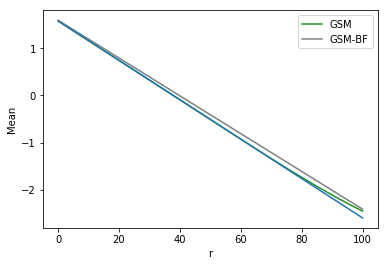

In [26]:
plt.plot(r, mean_interp(r), color = 'forestgreen',label = 'GSM')
plt.plot(r, mean_interp_bf(r), color='gray',label='GSM-BF')
plt.plot(r, mean_from_parameters)
plt.xlabel('r')
plt.ylabel('Mean')
plt.legend()

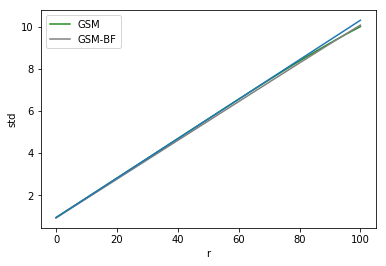

In [27]:
plt.plot(r, std_interp(r), color = 'forestgreen',label = 'GSM')
plt.plot(r, std_interp_bf(r), color='gray',label='GSM-BF')
plt.plot(r, std_from_parameters)

plt.xlabel('r')
plt.ylabel('std')
plt.legend()

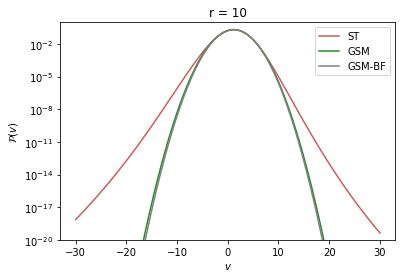

In [28]:
r_plot = 10
plt.title(f'r = {r_plot}')
plt.semilogy(v_los, st_pdf[r_plot], color='indianred', label = 'ST')
plt.semilogy(v_los, gauss_pdf[r_plot], color = 'forestgreen', label = 'GSM')
plt.semilogy(v_los, gauss_pdf_bf[r_plot], color = 'gray', label = 'GSM-BF')

plt.ylabel(r'$\mathcal{P}(v)$')
plt.xlabel(r'$v$')
plt.ylim(1e-20,1)
plt.legend()

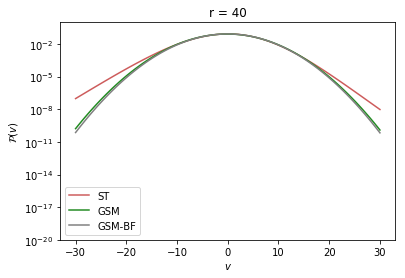

In [29]:
r_plot = 40
plt.title(f'r = {r_plot}')
plt.semilogy(v_los, st_pdf[r_plot], color='indianred', label = 'ST')
plt.semilogy(v_los, gauss_pdf[r_plot], color = 'forestgreen', label = 'GSM')
plt.semilogy(v_los, gauss_pdf_bf[r_plot], color = 'gray', label = 'GSM-BF')

plt.ylabel(r'$\mathcal{P}(v)$')
plt.xlabel(r'$v$')
plt.ylim(1e-20,1)

plt.legend()

## iii) With minus

In [30]:
def gsm(r, v, truncate = False):
    
    return norm.pdf(v, loc = mean_interp(abs(r)), scale = std_interp(abs(r)))

def gsm_bf(r, v, truncate = False):
    
    return norm.pdf(v, loc = mean_interp_bf(abs(r)), scale = std_interp_bf(abs(r)))

def stsm(r, v, truncate = False):
    pdf_contribution = np.zeros_like(v)
    if truncate:
        threshold = (v > np.min(v_los)) & (v < np.max(v_los))
        
        pdf_contribution[threshold] = truncated_skewt( v, vr_c,w(abs(r)), skewness,
                                                      kappa)[threshold]
    else:
        pdf_contribution = oned_skewt(v, vr_c,w(abs(r)), skewness, kappa)
    return pdf_contribution

In [31]:

def integrand_minus(r_parallel, pdf, s):
    v = (s - r_parallel) * np.sign(r_parallel)
    return pdf(r_parallel, v, truncate=True)

In [32]:
def integrate(integrand,r_parallel):
    left = r_parallel < 0.
    right = r_parallel > 0.
    
    return simps(integrand[left], r_parallel[left]) + simps(integrand[right], r_parallel[right])

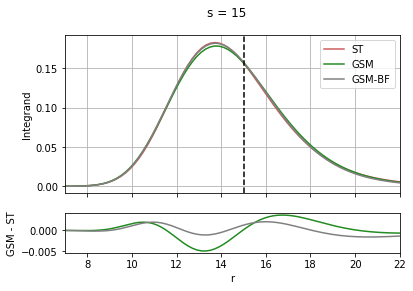

In [33]:
rparallel = np.linspace(-100., 100., 1000)
s = 15

fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})
plt.suptitle(f's = {s}')
ax1.plot(rparallel, integrand_minus(rparallel, stsm,s), label = 'ST', color = 'indianred')
ax1.plot(rparallel, integrand_minus(rparallel, gsm,s), label = 'GSM', color = 'forestgreen')
ax1.plot(rparallel, integrand_minus(rparallel, gsm_bf,s), label = 'GSM-BF', color = 'gray')

ax1.axvline(x=s, color='black', linestyle='dashed')
ax2.plot(rparallel, integrand_minus(rparallel, gsm,s)-integrand_minus(rparallel, stsm,s),
         label = 'GSM', color = 'forestgreen')
ax2.plot(rparallel, integrand_minus(rparallel, gsm_bf,s)-integrand_minus(rparallel, stsm,s),
         label = 'GSM', color = 'gray')
ax1.set_ylabel('Integrand')
ax2.set_ylabel('GSM - ST')

ax2.set_xlabel('r')
plt.xlim(7,22)
ax1.legend()
ax1.grid()

In [36]:
integrate(integrand_minus(rparallel,stsm,s), rparallel)

1.0540467895408976

In [37]:
integrate(integrand_minus(rparallel,gsm,s), rparallel)

1.0539452154411437

In [38]:
integrate(integrand_minus(rparallel,gsm_bf,s), rparallel)

1.0516922544222556

In [58]:
s_range = np.linspace(0.5,20.5,15)
gauss_int, gauss_int_bf, st_int = [], [], []
for s_value in s_range:
    st_int.append(integrate(integrand_minus(rparallel,stsm,s_value), rparallel))
    gauss_int.append(integrate(integrand_minus(rparallel,gsm,s_value), rparallel))
    gauss_int_bf.append(integrate(integrand_minus(rparallel,gsm_bf,s_value), rparallel))    

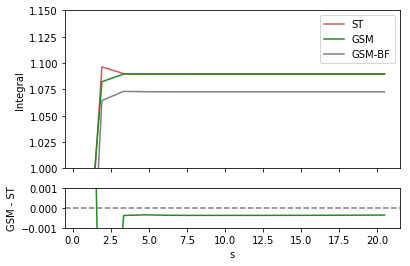

In [62]:
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex = True, squeeze = True,
                          gridspec_kw = {'height_ratios':[4,1]})
ax1.plot(s_range,st_int, label = 'ST', color = 'indianred')
ax1.plot(s_range, gauss_int, label = 'GSM', color = 'forestgreen')
ax1.plot(s_range, gauss_int_bf, label = 'GSM-BF', color = 'gray')

ax2.plot(s_range, np.asarray(gauss_int_bf) - np.asarray(st_int),
         label = 'GSM-BF', color = 'gray')

ax2.plot(s_range, np.asarray(gauss_int) - np.asarray(st_int),
         label = 'GSM', color = 'forestgreen')
ax1.set_ylabel('Integral')
ax2.set_ylabel('GSM - ST')

ax2.set_xlabel('s')
ax2.set_ylim(-0.001,0.001)
ax1.set_ylim(1.,1.15)
ax2.axhline(y = 0., linestyle='dashed', color='gray')
ax1.legend()